In [1]:
%load_ext autoreload
%autoreload 2


import sspspace
import numpy as np
import pandas as pd
import nengo
import scipy.special
import matplotlib.pyplot as plt
from scipy.stats import beta, norm

from nengo.config import Config
from nengo.ensemble import Ensemble
import nengo_dft
from dnf import DNF_BG_DYNDA
from utils import *

In [2]:
## create SSP encoder and neuron encoders

## set action space domain
domain = np.arange(0,4,0.01).reshape((-1,1))
## create SSP encoder
ssp_encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=512, 
                                      rng=np.random.RandomState(), 
                                      length_scale=0.5)
## encode domain as SSPs
domain_phis = ssp_encoder.encode(domain)

## Encoders
low = 0
high = 4
width = high - low
places_ = np.arange(low, high, width/400)
encoders = np.asarray(ssp_encoder.encode(places_.reshape(-1,1))).squeeze()

act_a_encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=512, 
                                      rng=np.random.RandomState(), 
                                      length_scale=0.5)

act_b_encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=512, 
                                      rng=np.random.RandomState(), 
                                      length_scale=0.5)

In [3]:
## Set DNF params

dnf_params = {
        'dnf_h'           : -3.009416816439706,
        'dnf_global_inhib': 8.641108231311897,
        'dnf_tau'         : 0.04706404390267922,
        'kernel_excit'    : 9.421285790349613,
        'kernel_inhib'    : 1.4841093480380807,
        'exc_width'       : 8.534993467227224,
        'inh_width'       : 4.748154014869723,
        'ens_dims'        : 512,
        'dec_neurons'     : 400,
    }

In [4]:
def run_net(stim, dnf_params, encoders, d1_weight=1.0, d2_weight=1.0, dopamine=[0.0]):
    ## Create nengo model
    model = nengo.Network()
    with model:
        
        inp_node = nengo.Node(nengo.processes.PresentInput([stim], presentation_time=1.5))

        da_node = nengo.Node(nengo.processes.PresentInput(dopamine, presentation_time=0.5))

        bg = DNF_BG_DYNDA(dnf_params=dnf_params,
                encoders=encoders,
                d1_weight=d1_weight,
                d2_weight=d2_weight,
                neuron_type=nengo.LIFRate())

        out_node = nengo.Node(size_in = 512)

        nengo.Connection(inp_node, bg.input, synapse=None)
        nengo.Connection(da_node, bg.dopamine, synapse=None)
        nengo.Connection(bg.output, out_node, synapse=None)

        p_in = nengo.Probe(inp_node, synapse=None)
        p_out = nengo.Probe(out_node, synapse=None)

    with nengo.Simulator(model) as sim:
        sim.run(1.5)

    return sim.data[p_in], sim.data[p_out]

# Model Assumptions

In this notebook we explore some of the assumptions of the basal ganglia model. We specifically test 3 assumptions: <br>
(1) the basal ganglia concentrates distributions of salience over continuous action spaces <br>
(2) when presented with two equally salient actions, the basal ganglia will select one of the actions, not the mean <br>
(3) dopamine modulates the explore-exploit trade-off via its interaction with the basal ganglia <br>

## Assumption #1

The basal ganglia concentrates distributions of salience over continuous action spaces. 

We test this assumption by providing the basal ganglia network with a unimodal distribution and observe whether the output is a concentrated version.  

Entropy ignoring 0's, H: 89.30543669936304


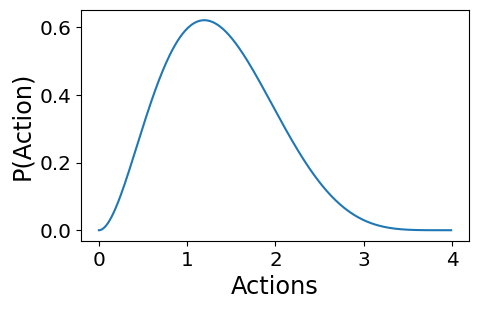

In [5]:
## Generate a unimodal distribution

## generate random values for the beta distribution
seed = 16
np.random.seed(seed)
a = np.random.uniform(1,10,1)
b = np.random.uniform(1,10,1)

## generate beta distribution
beta_Ps = beta.pdf(domain, a,b, scale=domain[-1])
print(f"Entropy ignoring 0's, H: {entropy(beta_Ps[beta_Ps != 0])}")
## encode as an SSP bundle
beta_pattern = gen_beta_cont_dist(beta_Ps.squeeze(), domain_phis)

plt.figure(figsize=(5,3))

plt.plot(domain, beta_Ps)
plt.xlabel("Actions", fontsize="xx-large")
plt.ylabel("P(Action)", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")

In [6]:
beta_inp, beta_out = run_net(beta_pattern, dnf_params, encoders)

c:\Users\maddy\anaconda3\envs\bgdlenv\lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## Assumption #2

When presented with two equally salient actions, the basal ganglia will select one of the actions, not the mean.

We test this assumption by providing the basal ganglia network with a bimodal distribution and observe whether the output is a concentrated version centred around one of the peaks, or a distribution centred at the mean of the two peaks. 

Entropy ignoring 0's, H: 118.97142730406935


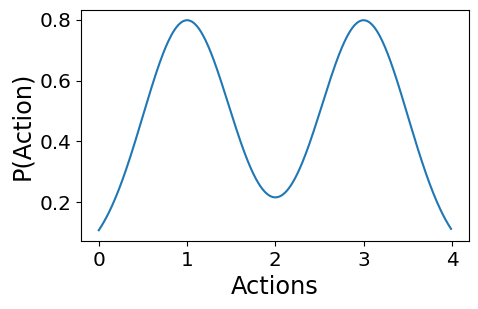

In [7]:
## generate two gaussian curves
mean1 = 1
sigma1 = 0.5
mean2 = 3
sigma2 = 0.5
Ps1 = norm.pdf(domain, mean1, sigma1)
Ps2 = norm.pdf(domain, mean2, sigma2)

## add them together to make a bimodal distribution
bimod_Ps = Ps1 + Ps2
print(f"Entropy ignoring 0's, H: {entropy(bimod_Ps[bimod_Ps != 0])}")
## encode as an SSP bundle
bimod_pattern = gen_beta_cont_dist(bimod_Ps.squeeze(), domain_phis)

plt.figure(figsize=(5,3))

plt.plot(domain, bimod_Ps)
plt.xlabel("Actions", fontsize="xx-large")
plt.ylabel("P(Action)", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")

In [8]:
bimod_inp, bimod_out = run_net(bimod_pattern, dnf_params, encoders)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## Assumption #3

Dopamine modulates the explore-exploit trade-off via its interaction with the basal ganglia

We test this assumption by providing the basal ganglia network with a unimodal distribution. We observe the height of the peak of the output distribution under three different dopamine conditions:
1) No Dopamine. $\text{DA} = 0.0$
2) Mid Dopamine. $\text{DA} = 0.4$
3) High Dopamine. $\text{DA} = 0.8$

Entropy ignoring 0's, H: 174.20613534539496


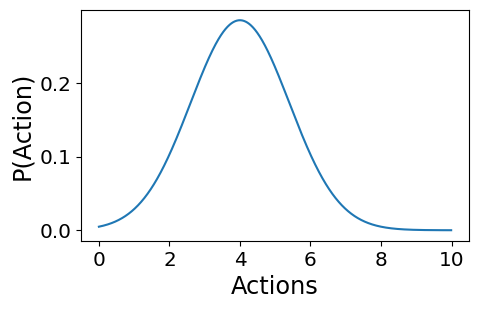

In [9]:
## generate a new SSP encoder for the larger action space
da_ssp_encoder = sspspace.encoders.RandomSSPSpace(domain_dim=1, ssp_dim=512, length_scale=0.5)

da_domain = np.arange(0,10,0.01)
da_domain_phis = da_ssp_encoder.encode(da_domain.reshape(-1,1))

## create a unimodel normal distribution
mean1 = 4
sigma1 = 1.4
Ps = norm.pdf(da_domain, mean1, sigma1)
print(f"Entropy ignoring 0's, H: {entropy(Ps[Ps != 0])}")


## encode as an SSP
stim = gen_beta_cont_dist(Ps.squeeze(), da_domain_phis)

plt.figure(figsize=(5,3))
plt.plot(da_domain, Ps)
plt.xlabel("Actions", fontsize="xx-large")
plt.ylabel("P(Action)", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")

In [10]:
## Update DNF params so there are 1,000 decoder neurons
dnf_params.update({"dec_neurons": 1000})
## Run the network
da_inp, da_out = run_net(stim, dnf_params, da_domain_phis, dopamine=[0.0,0.4,0.8])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

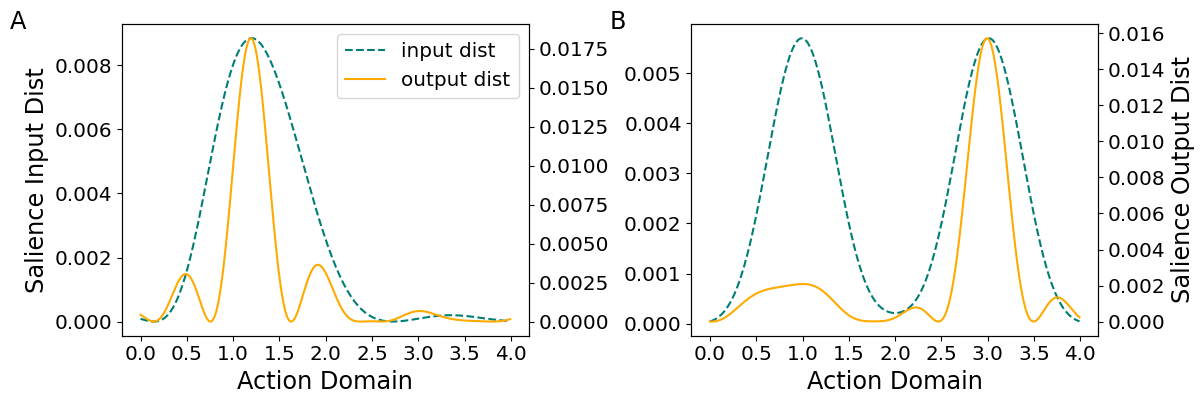

In [11]:
# inp_dec_uni = np.einsum('d,nd->n', beta_inp[-1], domain_phis)
# out_dec_uni = np.einsum('d,nd->n', beta_out[-1], domain_phis)
# inp_dec_bi = np.einsum('d,nd->n', bimod_inp[-1], domain_phis)
# out_dec_bi = np.einsum('d,nd->n', bimod_out[-1], domain_phis)

inp_dec_uni = born_prob(beta_inp[-1], domain_phis)
out_dec_uni = born_prob(beta_out[-1], domain_phis)
inp_dec_bi = born_prob(bimod_inp[-1], domain_phis)
out_dec_bi = born_prob(bimod_out[-1], domain_phis)

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(domain, inp_dec_uni, ls='--', color="#007e74", label=f"input dist")
ax1.set_ylabel('Salience Input Dist', fontsize='xx-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
ax2 = ax1.twinx()
ax2.plot(domain, out_dec_uni, ls='-', color="#ffaa00", label=f"output dist")
ax1.set_xlabel('Action Domain', fontsize='xx-large')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize='x-large')
plt.yticks(fontsize='x-large')

ax3 = fig.add_subplot(122)
ax3.plot(domain, inp_dec_bi, ls='--', color="#007e74", label=f'input dist H: {entropy(inp_dec_bi[inp_dec_bi != 0])}')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
ax4 = ax3.twinx()
ax4.plot(domain, out_dec_bi, ls='-', color="#ffaa00", label=f'output dist H: {entropy(out_dec_bi[out_dec_bi != 0])}')
ax4.set_ylabel('Salience Output Dist', fontsize='xx-large')
ax3.set_xlabel('Action Domain', fontsize='xx-large')
# h1, l1 = ax3.get_legend_handles_labels()
# h2, l2 = ax4.get_legend_handles_labels()
# ax3.legend(h1+h2, l1+l2, loc='upper left', fontsize='x-large')
plt.yticks(fontsize='x-large')

plt.tight_layout()
fig.text(0.0, 0.95, 'A', fontsize='xx-large')
fig.text(0.5, 0.95, 'B', fontsize='xx-large')
plt.savefig("./figs/assumps_1_2.pdf", bbox_inches='tight')


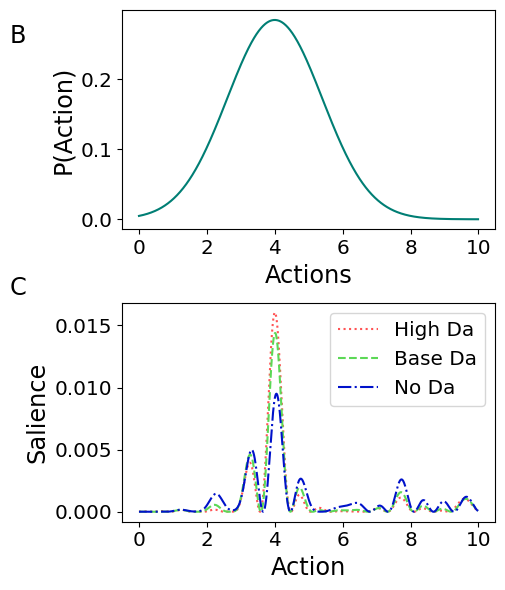

In [14]:
fig = plt.figure(figsize=(5,6))
plt.subplot(211)
plt.plot(da_domain, Ps, color="#007e74", label=f"H: {entropy(Ps[Ps != 0])}")
plt.xlabel("Actions", fontsize="xx-large")
plt.ylabel("P(Action)", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")

plt.subplot(212)
plt.plot(da_domain, born_prob(da_out[1499], da_domain_phis), color='#ff5354', ls=':', label=f"High Da")
plt.plot(da_domain, born_prob(da_out[999], da_domain_phis), color='#5cd856', ls='--', label=f"Base Da")
plt.plot(da_domain, born_prob(da_out[499], da_domain_phis), color='#0012ca', ls='-.', label=f"No Da")
plt.xticks([0,2,4,6,8,10], fontsize='x-large')
plt.xlabel('Action', fontsize='xx-large')
plt.ylabel('Salience', fontsize='xx-large')
plt.yticks(fontsize='x-large')
plt.legend(fontsize='x-large')

plt.tight_layout()
fig.text(0.0, 0.92, 'B', fontsize='xx-large')
fig.text(0.0, 0.5, 'C', fontsize='xx-large')
plt.savefig("./figs/assumps_3.pdf", bbox_inches='tight')